In [77]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.insert(0,'/home/garren/Documents/MEng/Code/Latest_results/HPC Files')
from All_code import subsets

In [78]:
functional_groups = np.array(['Alkane', 'Primary alcohol'])

In [79]:
subset_df, subset_Indices, subset_Indices_T, Info_Indices, init_indices, init_indices_T = subsets(functional_groups).get_subset_df()

In [80]:
Idx_known = subset_df.iloc[:,7:9].to_numpy()[subset_Indices_T[:,0],:]
c1 = []
c2 = []
x = []
T = []
y = []
for i in range(subset_Indices_T.shape[0]):
    c1 += [subset_df['Component 1'].to_numpy()[subset_Indices_T[i,0]]]
    c2 += [subset_df['Component 2'].to_numpy()[subset_Indices_T[i,0]]]
    x += [subset_df['Composition component 1 [mol/mol]'].to_numpy()[subset_Indices_T[i,0]:subset_Indices_T[i,1]+1]]
    T += [subset_df['Temperature [K]'].to_numpy()[subset_Indices_T[i,0]:subset_Indices_T[i,1]+1]]
    y += [subset_df['Excess Enthalpy [J/mol]'].to_numpy()[subset_Indices_T[i,0]:subset_Indices_T[i,1]+1]]

In [81]:
Kx = lambda x1, x2: np.column_stack([np.column_stack([x1**i+2 - x1 for i in range(3)]), 
                                     1e-1 * x1 * np.sqrt(1-x1) * np.exp(x1)]) @ np.column_stack([np.column_stack([x2**i+2 - x2 for i in range(3)]), 
                                     1e-1 * x2 * np.sqrt(1-x2) * np.exp(x2)]).T
KT = lambda T1, T2: np.column_stack([np.ones_like(T1), T1, T1**2, 1e-3*T1**3]) @ np.column_stack([np.ones_like(T2), T2, T2**2, 1e-3*T2**3]).T
K = lambda x1, x2, T1, T2: Kx(x1, x2) * KT(T1, T2)

In [82]:
idx_298_15 = np.array([np.sum(np.abs(TT-298.15)<0.5)>0 for TT in T])

In [116]:
random_choice = np.random.choice(np.where(idx_298_15)[0],3)

In [117]:
random_choice

array([ 7, 34, 77])

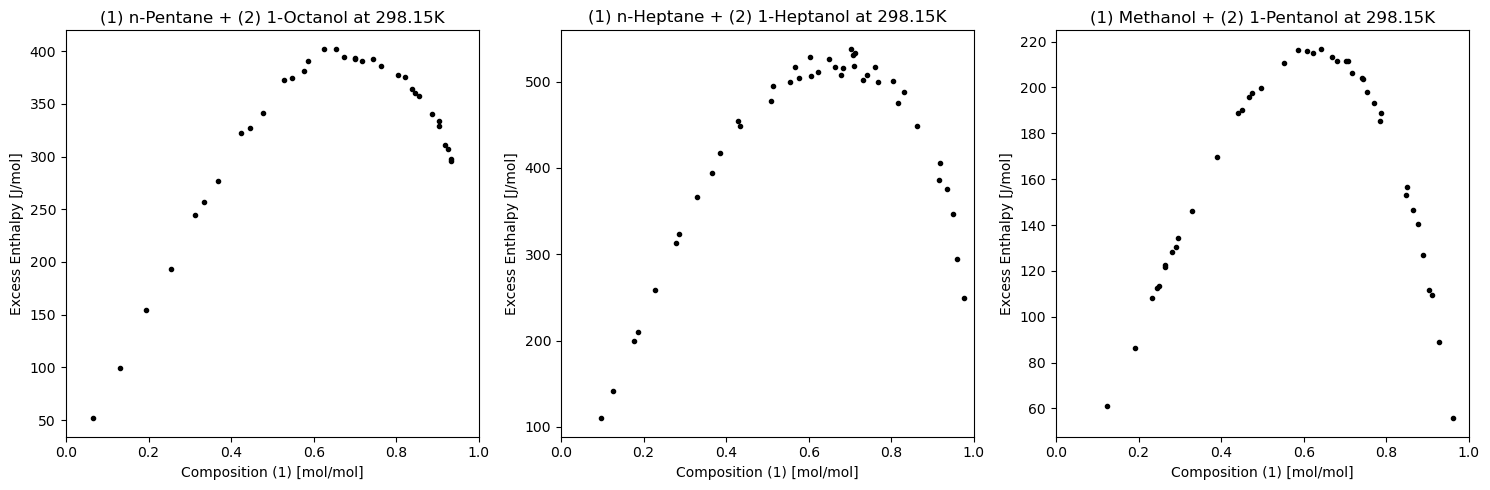

In [124]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
for i in range(3):
    T_idx = np.abs(T[random_choice[i]]-298.15)<0.5
    ax[i].plot(x[random_choice[i]][T_idx], y[random_choice[i]][T_idx], '.k')
    ax[i].set_xlabel(f'Composition (1) [mol/mol]')
    ax[i].set_ylabel('Excess Enthalpy [J/mol]')
    ax[i].set_title(f'(1) {c1[random_choice[i]]} + (2) {c2[random_choice[i]]} at 298.15K')
    ax[i].set_xlim([0,1])
plt.tight_layout()
fig.savefig('/home/garren/HPC Files/Pure_PMF_visual_exp_data.png', dpi=500)

In [119]:
y2 = []
x2 = np.linspace(0,1,21)[1:-1]
T2 = 298.15*np.ones_like(x2)
v = 1e-3
jitter=1e-7
for i in range(3):
    K1 = K(x[random_choice[i]], x[random_choice[i]], T[random_choice[i]], T[random_choice[i]])
    K21 = K(x2, x[random_choice[i]], T2, T[random_choice[i]])
    K2 = K(x2, x2, T2, T2)

    y1 = y[random_choice[i]]
    cov1 = K1 + np.diag((0.01*y1)**2+v+jitter)
    L1 = np.linalg.cholesky(cov1)
    L1_inv = np.linalg.inv(L1)
    y2 += [K21 @ (L1_inv.T @ L1_inv) @ y1]

    del K1, K21, K2, y1, cov1, L1, L1_inv

In [120]:
colours = [['r', 'orange', 'b'], 
           ['darkgreen', 'cyan', 'grey'],
           ['magenta', 'navy', 'sienna']]
symbols = ['.', '+', '<', '2', 'h', '4', 's', 'x', 'd', '*']
symbols += symbols[::-1][1:]

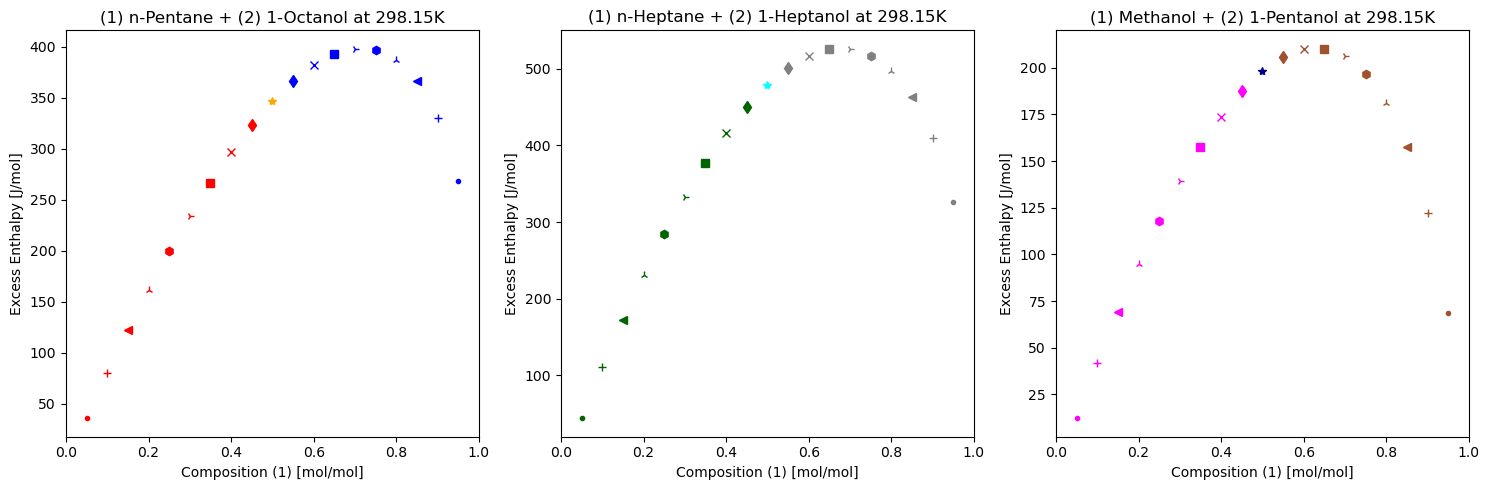

In [125]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
for i in range(3):
    for j in range(len(x2)):
        if x2[j]<0.5:
            color = colours[i][0]
        elif x2[j]==0.5:
            color = colours[i][1]
        elif x2[j]>0.5:
            color = colours[i][2]
        ax[i].plot(x2[j], y2[i][j], symbols[j], color=color) 
    ax[i].set_xlabel(f'Composition (1) [mol/mol]')
    ax[i].set_ylabel('Excess Enthalpy [J/mol]')
    ax[i].set_title(f'(1) {c1[random_choice[i]]} + (2) {c2[random_choice[i]]} at 298.15K')
    ax[i].set_xlim([0,1])
plt.tight_layout()
fig.savefig('/home/garren/HPC Files/Pure_PMF_visual_interp_data.png', dpi=500)

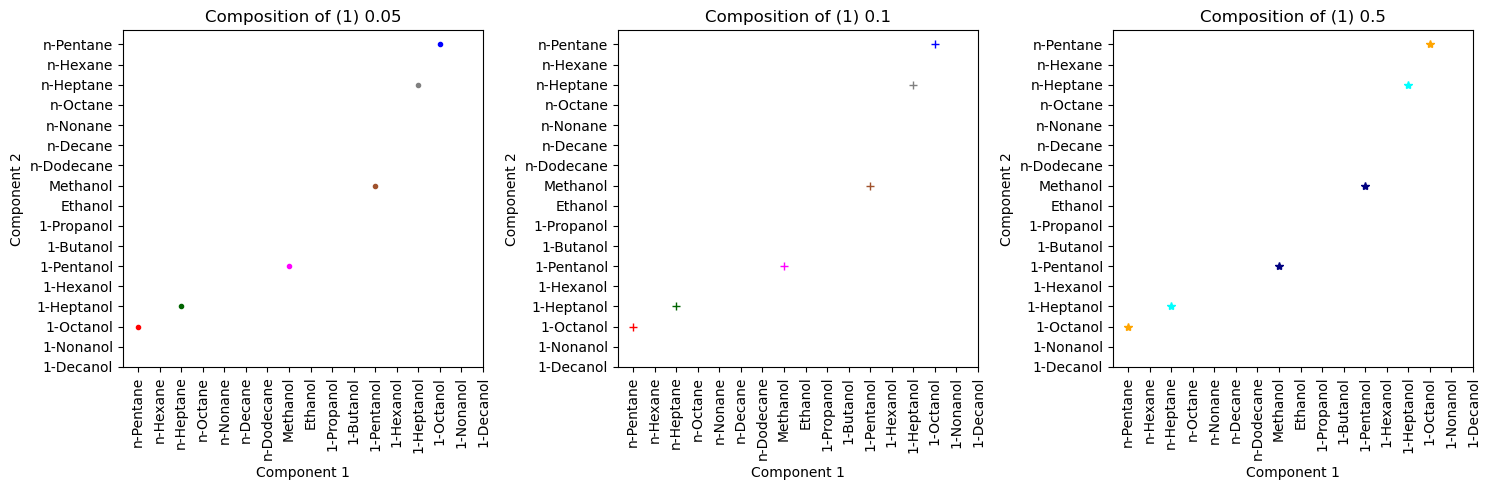

In [137]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
mat_idx = [0, 1, 9]
for i in range(3):
    for j in range(3):
        xmin = x2[mat_idx[i]]
        xmax = x2[-mat_idx[i]-1]
        xmin_sym = symbols[mat_idx[i]]
        xmax_sym = symbols[-mat_idx[i]-1]
        idxmin = Idx_known[random_choice[j],0]
        idxmax = Idx_known[random_choice[j],1]
        if xmin<0.5:
            xmin_color = colours[j][0]
        elif xmin==0.5:
            xmin_color = colours[j][1]
        elif xmin>0.5:
            xmin_color = colours[j][2]
        if xmax<0.5:
            xmax_color = colours[j][0]
        elif xmax==0.5:
            xmax_color = colours[j][1]
        elif xmax>0.5:
            xmax_color = colours[j][2]
        ax[i].plot(idxmin, idxmax, marker=xmin_sym, color=xmin_color)
        ax[i].plot(idxmax, idxmin, marker=xmax_sym, color=xmax_color)
    ax[i].set_title(f'Composition of (1) {xmin}')
    ax[i].set_yticks(range(len(Info_Indices['Component names']['IUPAC'])), Info_Indices['Component names']['IUPAC'])
    ax[i].set_xticks(range(len(Info_Indices['Component names']['IUPAC'])), Info_Indices['Component names']['IUPAC'], rotation=90)
    ax[i].set_ylabel('Component 2')
    ax[i].set_xlabel('Component 1')
    ax[i].invert_yaxis()
plt.tight_layout()
fig.savefig('/home/garren/HPC Files/Pure_PMF_visual_matrix_slices.png', dpi=500)

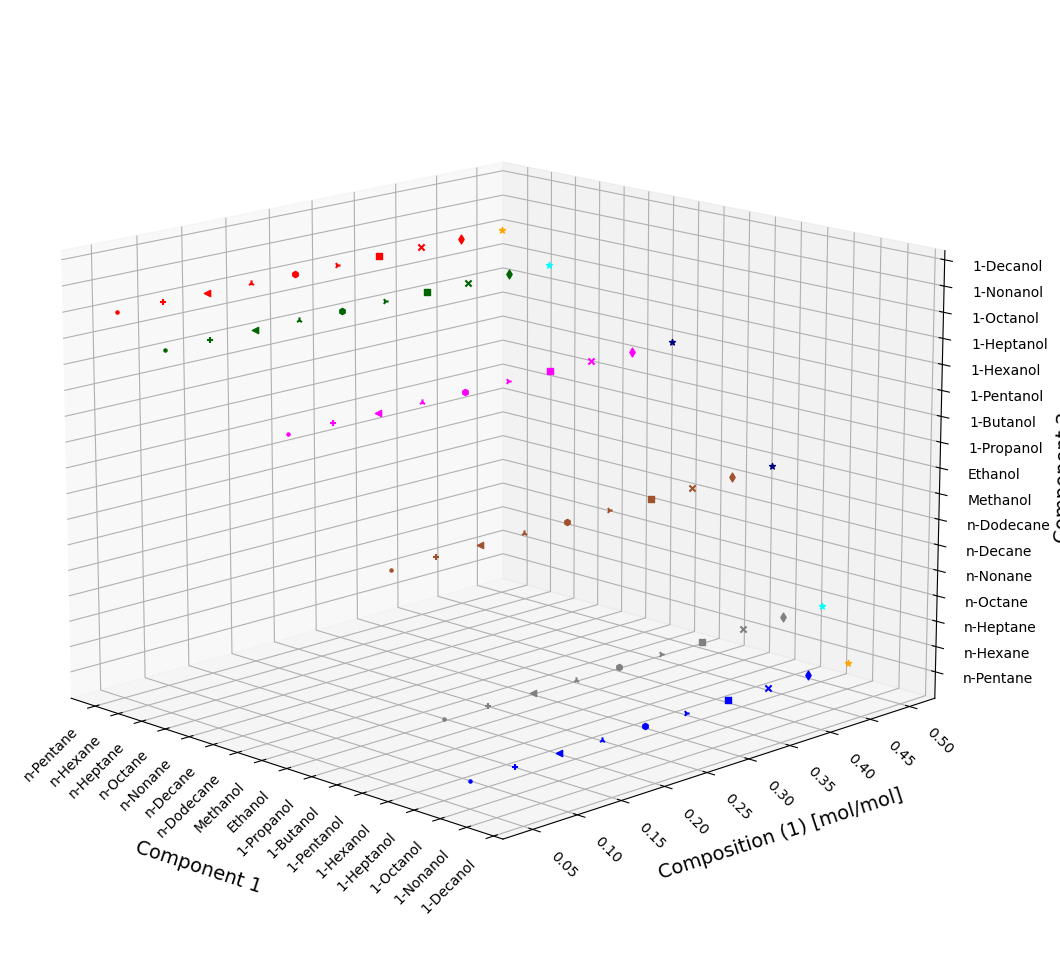

In [136]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(x2)):
    for j in range(3):
        if x2[i]<0.5:
            color = colours[j][0]
        elif x2[i]==0.5:
            color = colours[j][1]
        elif x2[i]>0.5:
            color = colours[j][2]
        if x2[i]<0.5:
            ax.scatter(Idx_known[random_choice[j],0], x2[i], Idx_known[random_choice[j],1], color=color, marker=symbols[i]) 
        elif x2[i]==0.5:
            ax.scatter(Idx_known[random_choice[j],0], x2[i], Idx_known[random_choice[j],1], color=color, marker=symbols[i])
            ax.scatter(Idx_known[random_choice[j],1], x2[i], Idx_known[random_choice[j],0], color=color, marker=symbols[i])
        elif x2[i]>0.5:
            ax.scatter(Idx_known[random_choice[j],1], 1-x2[i], Idx_known[random_choice[j],0], color=color, marker=symbols[i])

ax.set_xlabel('Component 1', fontsize=14, labelpad=40)
ax.set_ylabel('Composition (1) [mol/mol]', fontsize=14, labelpad=20)
ax.set_zlabel('Component 2', fontsize=14, labelpad=30)
ax.set_xticks(range(len(Info_Indices['Component names']['IUPAC'])), Info_Indices['Component names']['IUPAC'], ha='right', rotation=45)
ax.set_yticks(x2[:10], [f'{tick:.2f}' for tick in x2[:10]], ha='left', rotation=-45)
ax.set_zticks(range(len(Info_Indices['Component names']['IUPAC'])), Info_Indices['Component names']['IUPAC'], ha='left')
ax.view_init(elev=15, azim=-45)
# Manually adjust the margins to fit all labels and ticks
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
fig.savefig('/home/garren/HPC Files/Pure_PMF_visual_tensor_3D.png', dpi=500)

In [135]:
help(plt.subplots_adjust)

Help on function subplots_adjust in module matplotlib.pyplot:

subplots_adjust(left: 'float | None' = None, bottom: 'float | None' = None, right: 'float | None' = None, top: 'float | None' = None, wspace: 'float | None' = None, hspace: 'float | None' = None) -> 'None'
    Adjust the subplot layout parameters.

    Unset parameters are left unmodified; initial values are given by
    :rc:`figure.subplot.[name]`.

    Parameters
    ----------
    left : float, optional
        The position of the left edge of the subplots,
        as a fraction of the figure width.
    right : float, optional
        The position of the right edge of the subplots,
        as a fraction of the figure width.
    bottom : float, optional
        The position of the bottom edge of the subplots,
        as a fraction of the figure height.
    top : float, optional
        The position of the top edge of the subplots,
        as a fraction of the figure height.
    wspace : float, optional
        The width o